In [23]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [24]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1
p["errorbar.capsize"] = 2


In [25]:
def process(filename, headers, datas):
    header = np.loadtxt(filename, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, V_grill = header
    headers.append(header)

    data = np.loadtxt(filename, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append(np.array((V_in_combined, I_out_combined, I_out_std_combined)))

In [26]:
all_headers = [[], [], [], []]
all_datas = [[], [], [], []]
for run in glob('../data/position_grill/*'):
    process(run, all_headers[0], all_datas[0])
for run in glob('../data/position_pression/1.3e-3/*'):
    process(run, all_headers[1], all_datas[1])
for run in glob('../data/position_pression/6.9e-4/*'):
    process(run, all_headers[2], all_datas[2])
for run in glob('../data/position_pression/8.3e-3/*'):
    process(run, all_headers[3], all_datas[3])
all_headers[0][0][0], all_headers[1][0][0]

(np.float64(0.005), np.float64(0.0013))

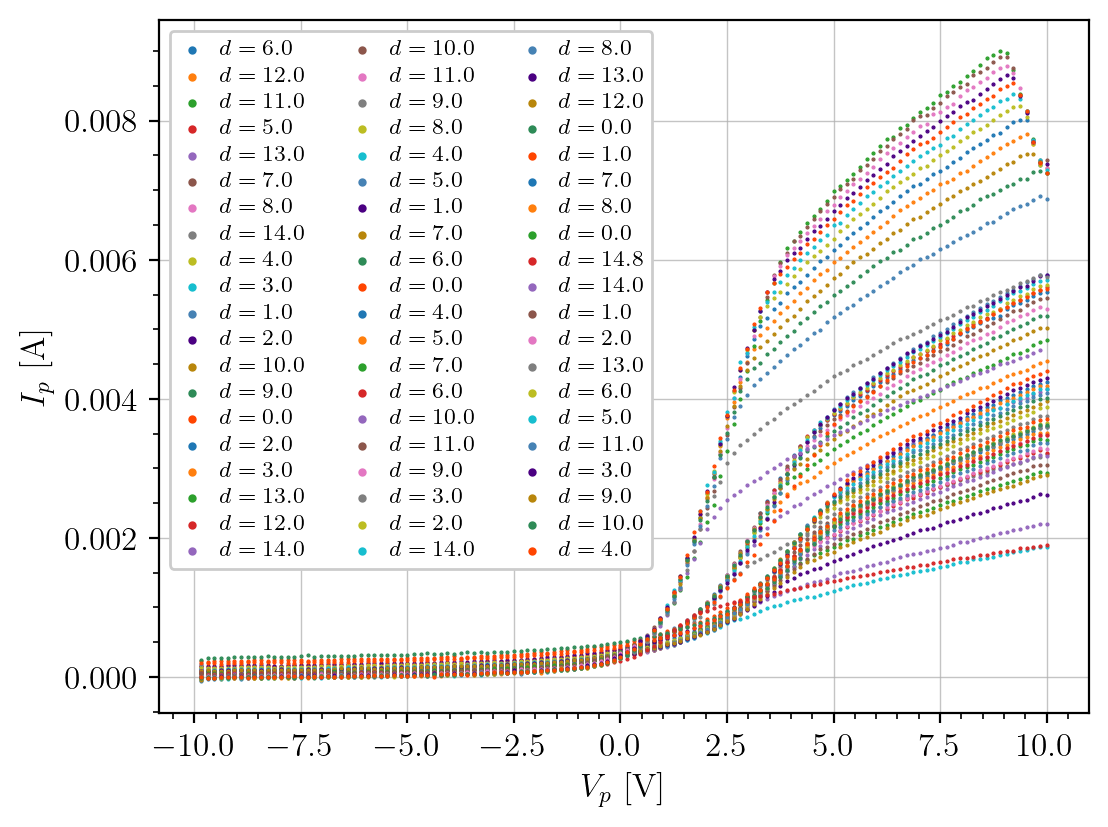

In [27]:
fig, ax = plt.subplots(1,1, dpi=200)
colors = list(plt.cm.tab10(np.arange(10))) + ["steelblue", "indigo", "darkgoldenrod", "seagreen", "orangered"]
ax.set_prop_cycle('color', colors)
plt.xlabel("$V_p$ [V]")
plt.ylabel("$I_p$ [A]")
for headers, datas in zip(all_headers, all_datas):
    for header, data in zip(headers, datas):
        p, d, G, A, f, I_chauffage, V_polarisation, V_grill = header
        V_in, I_out, I_out_std = data

        plt.scatter(V_in, I_out, label=f"$d = {d}$")

plt.legend(ncols=3, fontsize=8, markerscale=4)

## Find V_{sp}, ln(I_{es})

In [28]:
def set_all_between(arr):
    idx = np.nonzero(arr)[0]
    idx_start, idx_stop = idx[0], idx[-1]
    arr[idx_start:idx_stop+1] = True
    return arr

In [29]:
T_e = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))
T = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))
n_e = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))

for i, (headers, datas) in enumerate(zip(all_headers, all_datas)):
    for j, (header, data) in enumerate(zip(headers, datas)):
        p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
        V_in, I_out, I_out_std = data

        dydx = np.gradient(np.log(I_out), V_in)
        threshold = 7e-2
        idx = np.abs(np.diff(dydx, prepend=0)) < threshold
        idx = np.logical_and(idx, V_in > 0)
        idx_B = set_all_between(np.logical_and(idx, V_in < 3.5))
        idx_C = set_all_between(np.logical_and(idx, V_in > 7))
        # idx_B = np.logical_and(0 < V_in, V_in < 3)
        # idx_C = V_in > 6

        coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
        coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
        fitfuncB = np.poly1d(coefsB)
        coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
        coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
        fitfuncC = np.poly1d(coefsC)

        x = np.linspace(V_in[0], V_in[-1])
        plt.scatter(V_in, np.log(I_out), c='k')
        plt.plot(x, fitfuncB(x))
        plt.plot(x, fitfuncC(x))

        V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
        I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
        print(V_sp, I_sp)
        plt.axvline(V_sp.n)
        plt.axhline(umath.log(I_sp).n)

        T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
        T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
        # TODO: verifier unitées
        n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
        print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
        T_e[i, j] = T_e_run
        T[i, j] = T_run
        n_e[i, j] = n_e_run

        plt.gcf().delaxes(plt.gca())

4.09+/-0.05 0.00382+/-0.00005
T_e_run = (1.91±0.02)×10⁴, T_run = (1.64±0.01)×10⁰, n_e_run = (3.53±0.05)×10¹⁶
3.87+/-0.05 0.003069+/-0.000033
T_e_run = (1.98±0.02)×10⁴, T_run = (1.71±0.02)×10⁰, n_e_run = (2.78±0.03)×10¹⁶
3.92+/-0.04 0.003281+/-0.000035
T_e_run = (1.93±0.01)×10⁴, T_run = (1.66±0.01)×10⁰, n_e_run = (3.01±0.03)×10¹⁶
4.15+/-0.04 0.00386+/-0.00004
T_e_run = (1.92±0.01)×10⁴, T_run = (1.66±0.01)×10⁰, n_e_run = (3.56±0.04)×10¹⁶
3.76+/-0.05 0.002772+/-0.000027
T_e_run = (1.98±0.02)×10⁴, T_run = (1.71±0.02)×10⁰, n_e_run = (2.51±0.02)×10¹⁶
4.04+/-0.04 0.00374+/-0.00004
T_e_run = (1.89±0.02)×10⁴, T_run = (1.63±0.01)×10⁰, n_e_run = (3.47±0.04)×10¹⁶
4.04+/-0.04 0.00368+/-0.00005
T_e_run = (1.90±0.01)×10⁴, T_run = (1.64±0.01)×10⁰, n_e_run = (3.40±0.05)×10¹⁶
3.54+/-0.10 0.002118+/-0.000024
T_e_run = (2.13±0.05)×10⁴, T_run = (1.84±0.04)×10⁰, n_e_run = (1.85±0.02)×10¹⁶
4.23+/-0.05 0.00389+/-0.00005
T_e_run = (1.96±0.02)×10⁴, T_run = (1.69±0.01)×10⁰, n_e_run = (3.55±0.05)×10¹⁶
4.32+/-0.07

/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_48470/416046677.py:10: RuntimeWarning: invalid value encountered in log
  dydx = np.gradient(np.log(I_out), V_in)
/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_48470/416046677.py:27: RuntimeWarning: invalid value encountered in log
  plt.scatter(V_in, np.log(I_out), c='k')


<Figure size 780x585 with 0 Axes>

In [30]:
distances_0 = list(map(lambda header: header[1], all_headers[0]))
distances_1 = list(map(lambda header: header[1], all_headers[1]))
distances_2 = list(map(lambda header: header[1], all_headers[2]))
distances_3 = list(map(lambda header: header[1], all_headers[3]))

## Temperature des électrons en fonction de la position pour differentes pressions

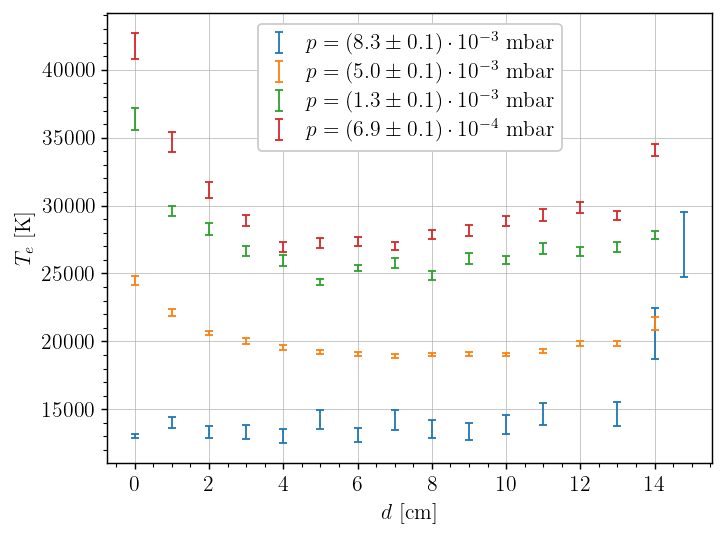

In [31]:
plt.errorbar(distances_3, nom_vals(T_e[3]), yerr=std_devs(T_e[3]), ls='',
             label=r"$p = (8.3\pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_0, nom_vals(T_e[0]), yerr=std_devs(T_e[0]), ls='',
             label=r"$p = (5.0 \pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_1, nom_vals(T_e[1]), yerr=std_devs(T_e[1]), ls='',
             label=r"$p = (1.3\pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_2, nom_vals(T_e[2]), yerr=std_devs(T_e[2]), ls='',
             label=r"$p = (6.9\pm 0.1) \cdot 10^{-4}$ mbar")
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$T_e$ [K]')
plt.legend()
plt.savefig("../figures/temperatureK_position.pdf")

### Temperature de électrons (mais en eV)

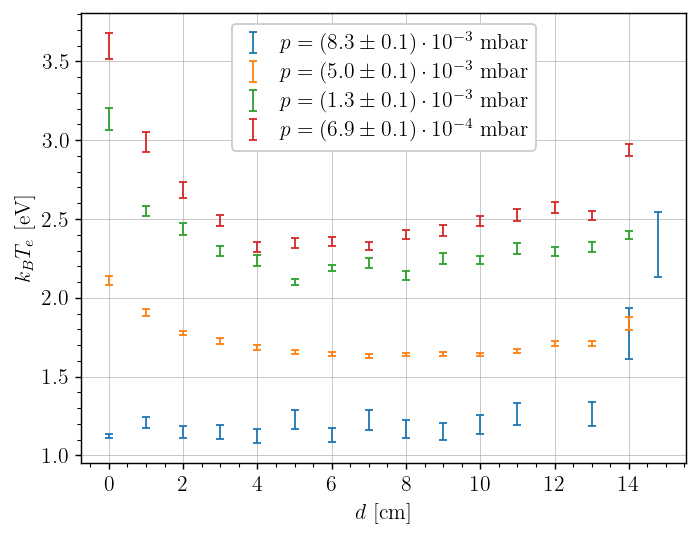

In [32]:
plt.errorbar(distances_3, nom_vals(T[3]), yerr=std_devs(T[3]), ls='',
             label=r"$p = (8.3\pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_0, nom_vals(T[0]), yerr=std_devs(T[0]), ls='',
             label=r"$p = (5.0 \pm 0.1)\cdot 10^{-3}$ mbar")
plt.errorbar(distances_1, nom_vals(T[1]), yerr=std_devs(T[1]), ls='',
             label=r"$p = (1.3\pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_2, nom_vals(T[2]), yerr=std_devs(T[2]), ls='',
             label=r"$p = (6.9\pm 0.1) \cdot 10^{-4}$ mbar")
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$k_B T_e$ [eV]')
plt.legend()
plt.savefig("../figures/temperatureeV_position.pdf")

## Densité d'electrons en differentes position pour differentes pressions

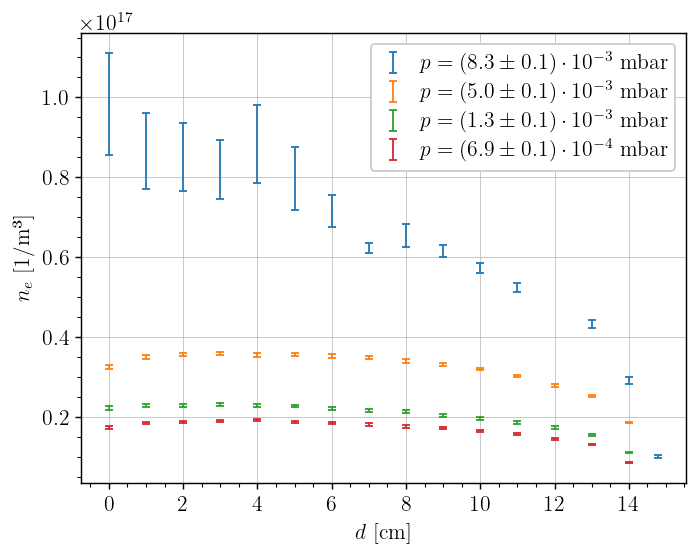

In [33]:
plt.errorbar(distances_3, nom_vals(n_e[3]), yerr=std_devs(n_e[3]), ls='',
             label=r"$p = (8.3 \pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_0, nom_vals(n_e[0]), yerr=std_devs(n_e[0]), ls='',
             label=r"$p = (5.0 \pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_1, nom_vals(n_e[1]), yerr=std_devs(n_e[1]), ls='',
             label=r"$p = (1.3 \pm 0.1) \cdot 10^{-3}$ mbar")
plt.errorbar(distances_2, nom_vals(n_e[2]), yerr=std_devs(n_e[2]), ls='',
             label=r"$p = (6.9 \pm 0.1) \cdot 10^{-4}$ mbar")
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$n_e$ [1/m³]')
plt.legend()
plt.savefig("../figures/density_position.pdf")